<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/MIAP/blob/main/MIAP_PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Q1***

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import nibabel as nib

file_path = '/content/drive/MyDrive/MIAP/sub-0001_space-MNI_T1w.nii'

imges = nib.load(file_path)

arrays_of_data = imges.get_fdata()

print(f'Shape: {arrays_of_data.shape}')
print(f'Data type: {arrays_of_data.dtype}')

Shape: (207, 243, 226)
Data type: float64


In [4]:
import numpy as np
import matplotlib.pyplot as plt
slice_90 = arrays_of_data[:, :, 90]


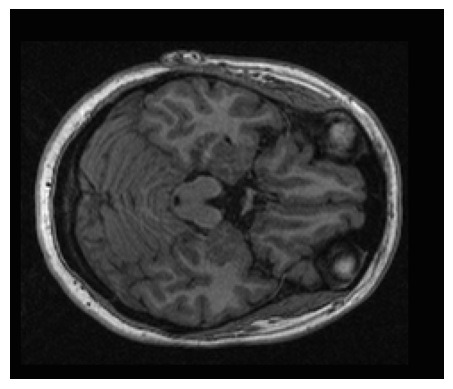

(-0.5, 179.5, 179.5, -0.5)

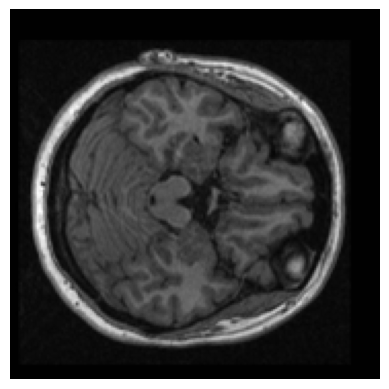

In [5]:
from PIL import Image
plt.imshow(slice_90, cmap='gray')
plt.axis('off')
plt.savefig('slice_90.png', bbox_inches='tight', pad_inches=0)
plt.show()
loaded_img = plt.imread('slice_90.png')

norm_img = np.array(loaded_img / np.max(loaded_img))
resized_img = Image.fromarray((norm_img*255 ).astype(np.uint8))


# Resize the image to 180x180
resized_img = (resized_img.resize((180, 180)))
resized_img=resized_img.convert('L')
resized_img.save('mri_reshaped.png')
plt.imshow(resized_img, cmap='gray')
plt.axis('off')


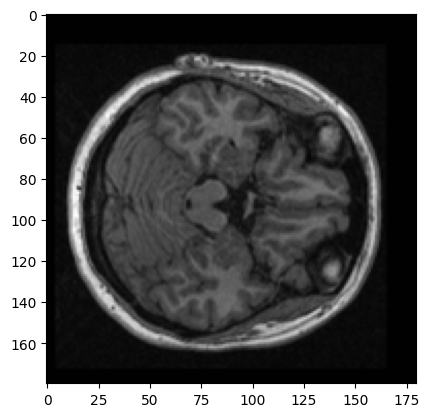

In [6]:

mri_reshaped = plt.imread('mri_reshaped.png')
mri_reshaped=mri_reshaped/np.max(np.max(mri_reshaped))
plt.imshow(mri_reshaped, cmap='gray')

In [7]:
print(np.max(np.max(mri_reshaped)))

1.0


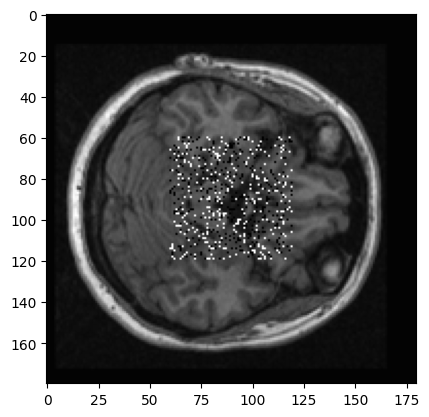

In [8]:

def add_salt_and_pepper_noise(image, amount):
    noisy_image = np.copy(image)
    height, width = image.shape
    num_noise_pixels = int(amount * height * width)
    salt_coords = [np.random.randint(0, dim, num_noise_pixels) for dim in [height, width]]
    for i in range(num_noise_pixels):
      noisy_image[salt_coords[0][i]][salt_coords[1][i]] = 1
    pepper_coords = [np.random.randint(0, dim, num_noise_pixels) for dim in [height, width]]
    for i in range(num_noise_pixels):
      noisy_image[pepper_coords[0][i]][pepper_coords[1][i]]  = 0
    return noisy_image
def add_noise_to_center(image, noise_dimension, amount):
    noisy_image = np.copy(image)
    height, width = image.shape
    noise_height, noise_width = noise_dimension
    center_x = int((width - noise_width) / 2)
    center_y = int((height - noise_height) / 2)
    center_patch = noisy_image[center_y:center_y+noise_height, center_x:center_x+noise_width]
    noisy_center_patch = add_salt_and_pepper_noise(center_patch, amount)
    noisy_image[center_y:center_y+noise_height, center_x:center_x+noise_width] = noisy_center_patch
    return noisy_image
noisy_center_image = add_noise_to_center(mri_reshaped, (60, 60), 0.1)
plt.imshow(noisy_center_image, cmap='gray')


In [9]:
def calculate_block_variance(block):
  return np.var(block)

block_size = 60
block_cords = []
for i in range(int(len(noisy_center_image)/block_size)):
  for j in range(int(len(noisy_center_image)/block_size)):
    block_cords.append([i*block_size,j*block_size])

variances = []
for i in range(len(block_cords)):
  variances.append(calculate_block_variance(noisy_center_image[block_cords[i][0]:block_cords[i][0]+block_size,block_cords[i][1]:block_cords[i][1]+block_size]))
max_block_var=block_cords[variances.index(max(variances))]

In [10]:
max_block_var

[60, 60]

In [11]:
variances

[0.036611117,
 0.0332658,
 0.02975287,
 0.038536105,
 0.057612613,
 0.028509017,
 0.034470852,
 0.025085276,
 0.027842063]

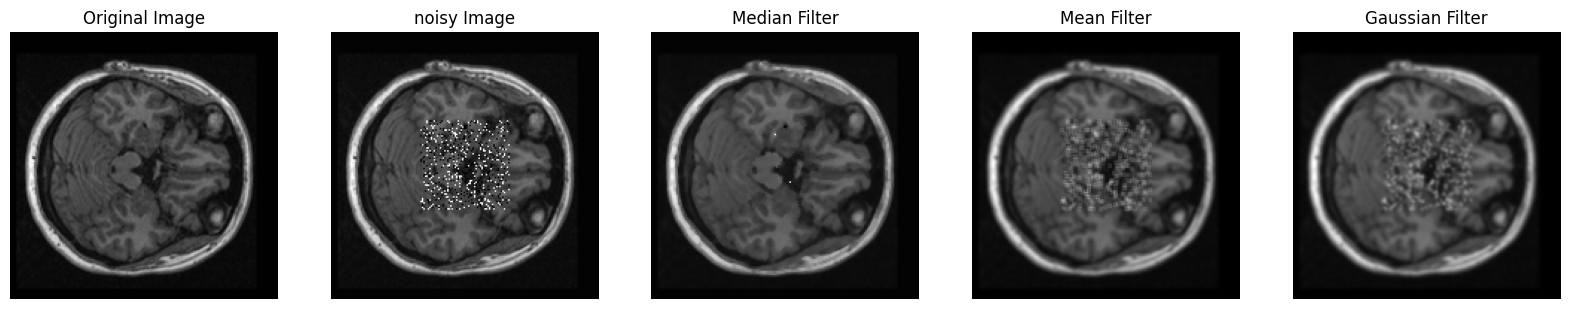

In [12]:
from scipy.ndimage import median_filter, uniform_filter, gaussian_filter
import matplotlib.pyplot as plt

# Assuming 'image' is the original image and 'max_location' is the location of the block with maximum variance

# Extract the block with maximum variance
max_variance_block = noisy_center_image[max_block_var[0]:max_block_var[0]+block_size,max_block_var[1]:max_block_var[1]+block_size]

# Apply median filter to remove salt and pepper noise
filtered_image_median = median_filter(noisy_center_image, size=3)

# Apply mean filter to remove salt and pepper noise
filtered_image_mean = uniform_filter(noisy_center_image, size=3)

# Apply Gaussian filter to remove salt and pepper noise
filtered_image_gaussian = gaussian_filter(noisy_center_image, sigma=1)

plt.figure(figsize=(20, 20))

plt.subplot(1,5, 1)
plt.imshow(mri_reshaped, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(noisy_center_image, cmap='gray')
plt.title('noisy Image')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(filtered_image_median, cmap='gray')
plt.title('Median Filter')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(filtered_image_mean, cmap='gray')
plt.title('Mean Filter')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(filtered_image_gaussian, cmap='gray')
plt.title('Gaussian Filter')
plt.axis('off')

plt.show()


In [13]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error

# Calculate SSIM and MAE for each filtered image
ssim_median = ssim(mri_reshaped, filtered_image_median)
ssim_mean = ssim(mri_reshaped, filtered_image_mean)
ssim_gaussian = ssim(mri_reshaped, filtered_image_gaussian)

mae_median = mean_absolute_error(mri_reshaped.flatten(), filtered_image_median.flatten())
mae_mean = mean_absolute_error(mri_reshaped.flatten(), filtered_image_mean.flatten())
mae_gaussian = mean_absolute_error(mri_reshaped.flatten(), filtered_image_gaussian.flatten())

# Compare the results
print("SSIM for Median Filtered Image:", ssim_median)
print("SSIM for Uniform Filtered Image:", ssim_mean)
print("SSIM for Gaussian Filtered Image:", ssim_gaussian)

print("MAE for Median Filtered Image:", mae_median)
print("MAE for Uniform Filtered Image:", mae_mean)
print("MAE for Gaussian Filtered Image:", mae_gaussian)


SSIM for Median Filtered Image: 0.9763172339549081
SSIM for Uniform Filtered Image: 0.9182131946379606
SSIM for Gaussian Filtered Image: 0.9209148699332363
MAE for Median Filtered Image: 0.008475257
MAE for Uniform Filtered Image: 0.020288397
MAE for Gaussian Filtered Image: 0.020730618


#***Q2***

<ipython-input-14-b61d9c5cfe62>:16: RuntimeWarning: divide by zero encountered in log
  log_transformed = c * np.log(1 + image)
<ipython-input-14-b61d9c5cfe62>:17: RuntimeWarning: invalid value encountered in cast
  log_transformed = np.uint8(log_transformed)


(-0.5, 353.5, 339.5, -0.5)

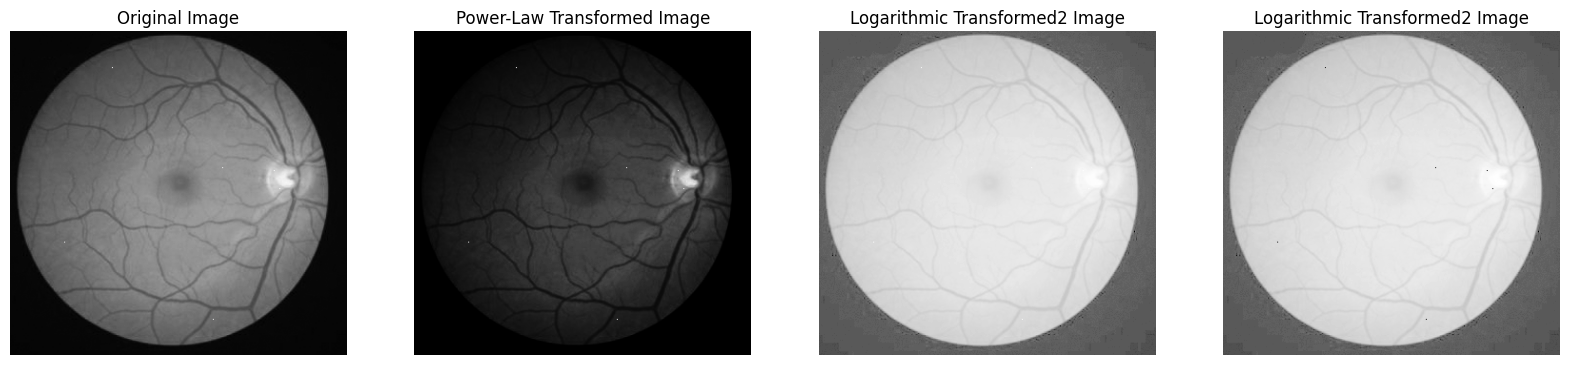

In [14]:
import cv2
import numpy as np

# Load the image
file_path = '/content/drive/MyDrive/MIAP/retina.png'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Power-Law transformation
gamma =2.5  # You can adjust this parameter
power_law_image = np.power(image/255.0, gamma) * 255.0
power_law_image = np.uint8(power_law_image)

# Logarithmic transformation
logarithmic_image = np.log1p(image) * 255 / np.log1p(255)
c = 255/(np.log(1 + np.max(image)))
log_transformed = c * np.log(1 + image)
log_transformed = np.uint8(log_transformed)
logarithmic_image = np.uint8(logarithmic_image)

# Display the original and transformed images

plt.figure(figsize=(20, 20))

plt.subplot(1,4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4, 2)
plt.imshow(power_law_image, cmap='gray')
plt.title('Power-Law Transformed Image')
plt.axis('off')

plt.subplot(1,4, 3)
plt.imshow(logarithmic_image, cmap='gray')
plt.title('Logarithmic Transformed2 Image')
plt.axis('off')

plt.subplot(1,4, 4)
plt.imshow(log_transformed, cmap='gray')
plt.title('Logarithmic Transformed2 Image')
plt.axis('off')



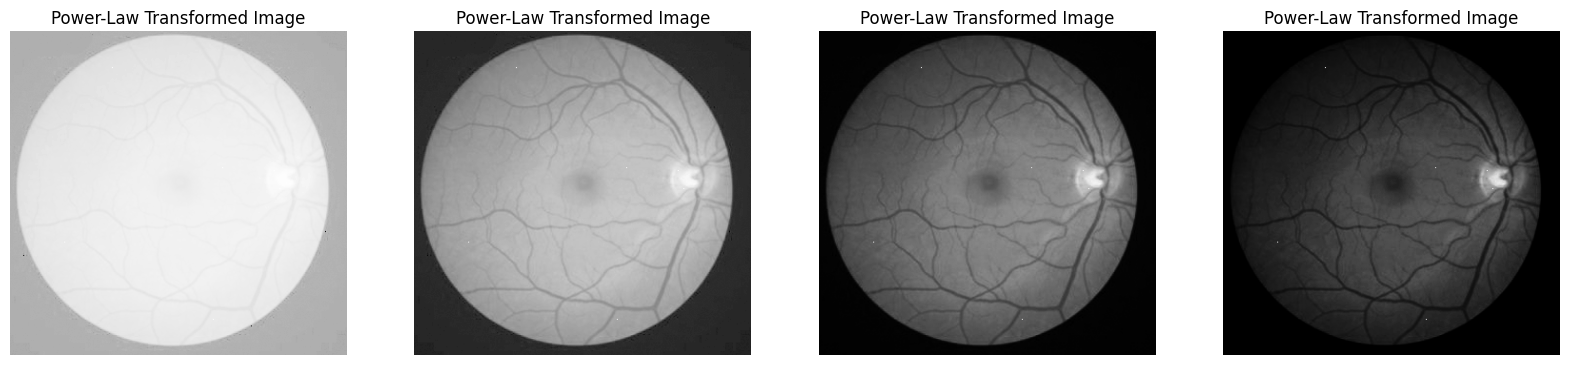

In [15]:
i=0
plt.figure(figsize=(20, 20))
for gamma in [0.1, 0.5, 1.2, 2.2]:
  i=i+1
  power_law_image = np.power(image/255.0, gamma) * 255.0
  power_law_image = np.uint8(power_law_image)
  plt.subplot(1,4, i)
  plt.imshow(power_law_image, cmap='gray')
  plt.title('Power-Law Transformed Image')
  plt.axis('off')

#***Q3***

(-0.5, 799.5, 899.5, -0.5)

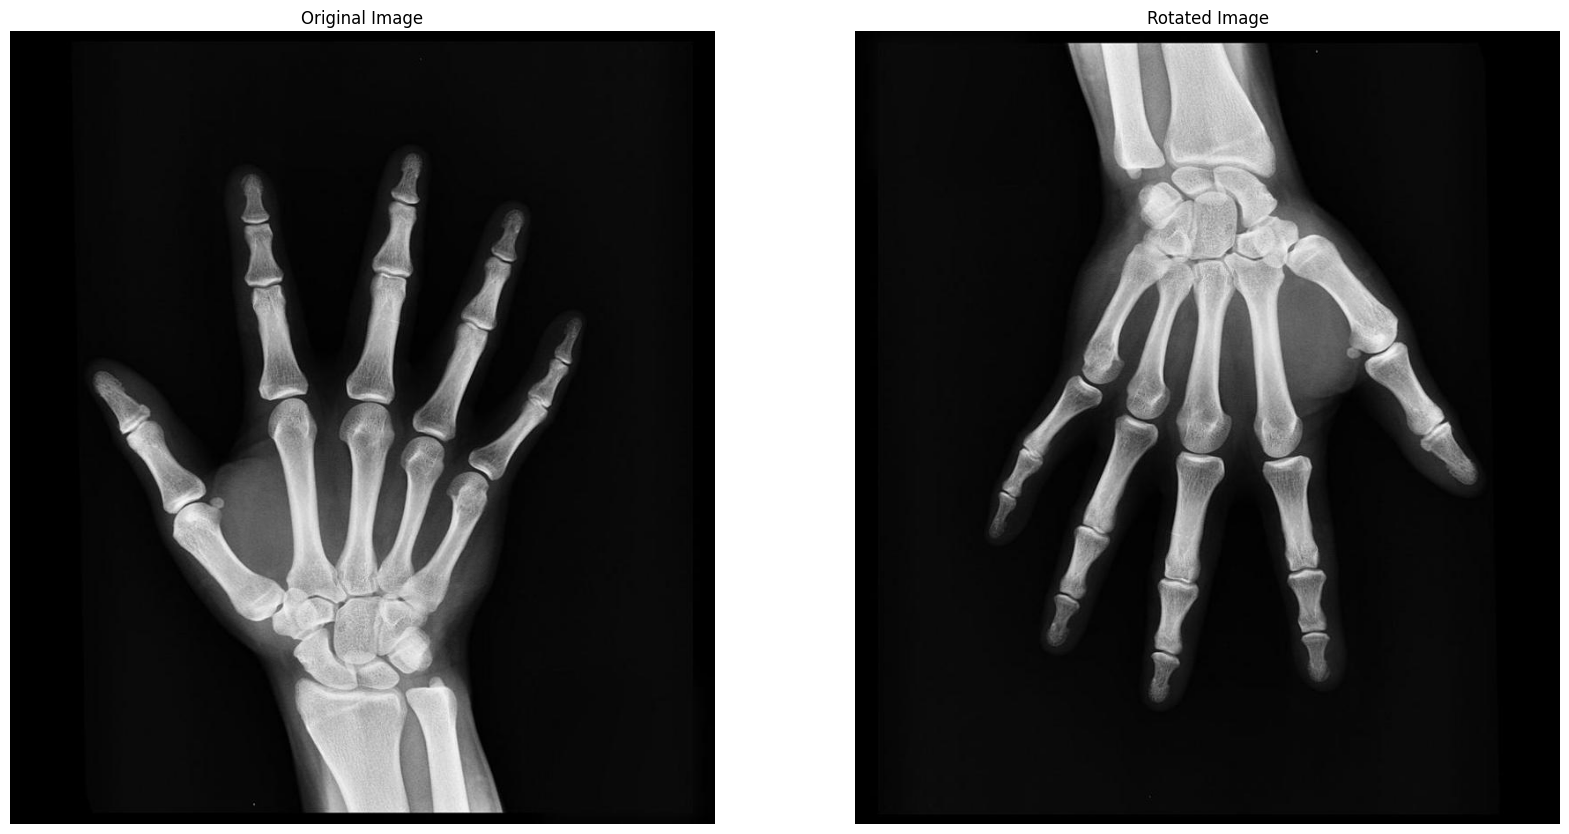

In [16]:
import numpy as np
from scipy.ndimage import rotate
from scipy.fftpack import fft2,ifft2,fftshift,ifftshift
from matplotlib.pyplot import subplots,cm

# Load the image
file_path = '/content/drive/MyDrive/MIAP/hand_xray.jpg'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

F_img = fftshift(fft2(image))
angle=180
r = rotate(F_img.real,angle,reshape=False,mode='wrap')
i = rotate(F_img.imag,angle,reshape=False,mode='wrap')
rF_img= r+1j*i
IrF_img = np.abs(ifft2(ifftshift(rF_img)))

plt.figure(figsize=(20, 20))
plt.subplot(1,2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(IrF_img, cmap='gray')
plt.title('Rotated Image')
plt.axis('off')

#***Q4***

(-0.5, 240.5, 151.5, -0.5)

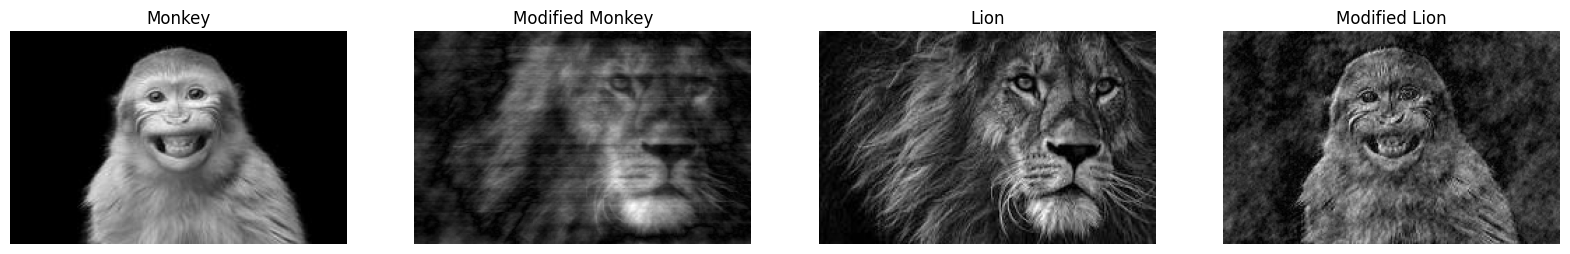

In [17]:
import cv2
import numpy as np

# Load the images
file_path1 = '/content/drive/MyDrive/MIAP/monkey.jpg'
file_path2 = '/content/drive/MyDrive/MIAP/lion.jpg'
image1 = cv2.imread(file_path1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(file_path2, cv2.IMREAD_GRAYSCALE)

# Perform 2D Fourier Transform on the images

fshift1 = fftshift(fft2(image1))
fshift2 = fftshift(fft2(image2))

# Swap the phases of the Fourier Transforms
magnitude1, phase1 = cv2.cartToPolar(np.real(fshift1), np.imag(fshift1))
magnitude2, phase2 = cv2.cartToPolar(np.real(fshift2), np.imag(fshift2))

relfshift_m1p2, imfshift_m1p2 = (cv2.polarToCart(magnitude1, phase2))
relfshift_m2p1, imfshift_m2p1 = (cv2.polarToCart(magnitude2, phase1))
fshift_m1p2= relfshift_m1p2+1j*imfshift_m1p2
fshift_m2p1= relfshift_m2p1+1j*imfshift_m2p1
# Perform inverse Fourier Transform
image_m1p2 = ifft2(ifftshift(fshift_m1p2))
image_m1p2 = np.abs(image_m1p2)
image_m2p1 = ifft2(ifftshift(fshift_m2p1))
image_m2p1 = np.abs(image_m2p1)



# Display the original and modified images
plt.figure(figsize=(20, 20))
plt.subplot(1,4, 1)
plt.imshow(image1, cmap='gray')
plt.title('Monkey')
plt.axis('off')

plt.subplot(1,4, 2)
plt.imshow(image_m1p2, cmap='gray')
plt.title('Modified Monkey')
plt.axis('off')

plt.subplot(1,4, 3)
plt.imshow(image2, cmap='gray')
plt.title('Lion')
plt.axis('off')

plt.subplot(1,4, 4)
plt.imshow(image_m2p1, cmap='gray')
plt.title('Modified Lion')
plt.axis('off')

#***Q5***

(-0.5, 353.5, 339.5, -0.5)

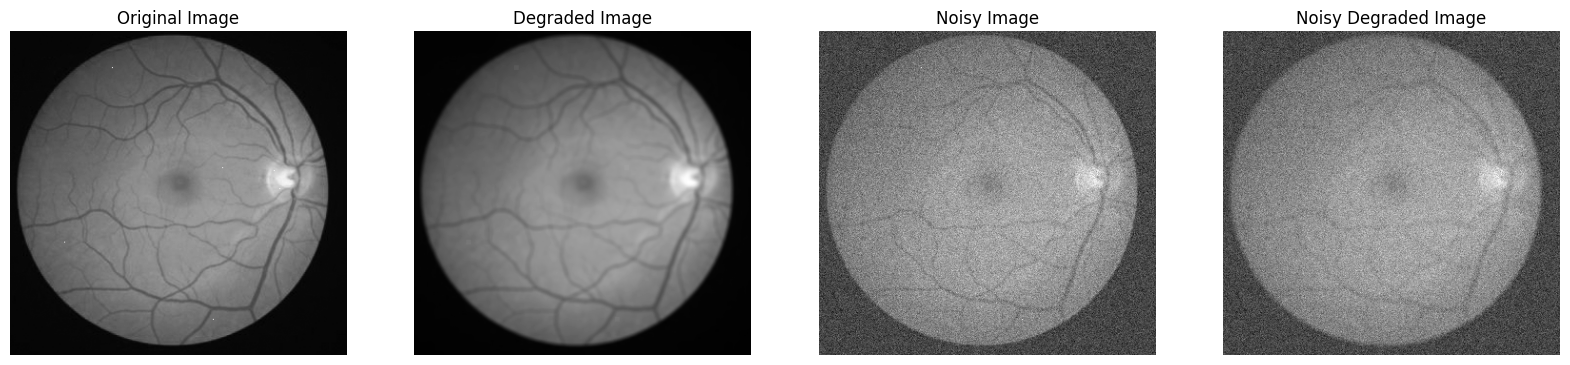

In [18]:
import cv2
import numpy as np

def degredation_filter(image, filter_size):
    return cv2.blur(image, (filter_size, filter_size))

def calculate_psnr(original_image, reconstructed_image):
    mse = np.mean((original_image - reconstructed_image) ** 2)
    psnr = 10 * np.log10((255 ** 2) / mse)
    return psnr
# Load the image

file_path = '/content/drive/MyDrive/MIAP/retina.png'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Apply degradation function (blur)
degraded_image = degredation_filter(image, 5)

# Add Gaussian noise to the image
noise = np.random.normal(0, 25, image.shape)
noisy_image = image + noise

noisy_degraded_img = degraded_image +noise

# Display the original and modified images
plt.figure(figsize=(20, 20))
plt.subplot(1,4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image')
plt.axis('off')

plt.subplot(1,4, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1,4, 4)
plt.imshow(noisy_degraded_img, cmap='gray')
plt.title('Noisy Degraded Image')
plt.axis('off')


/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


PSNR for degraded image: nan dB
PSNR for noisy image: 30.683896579897024 dB
PSNR for reconstructed image: 29.68158599834528 dB


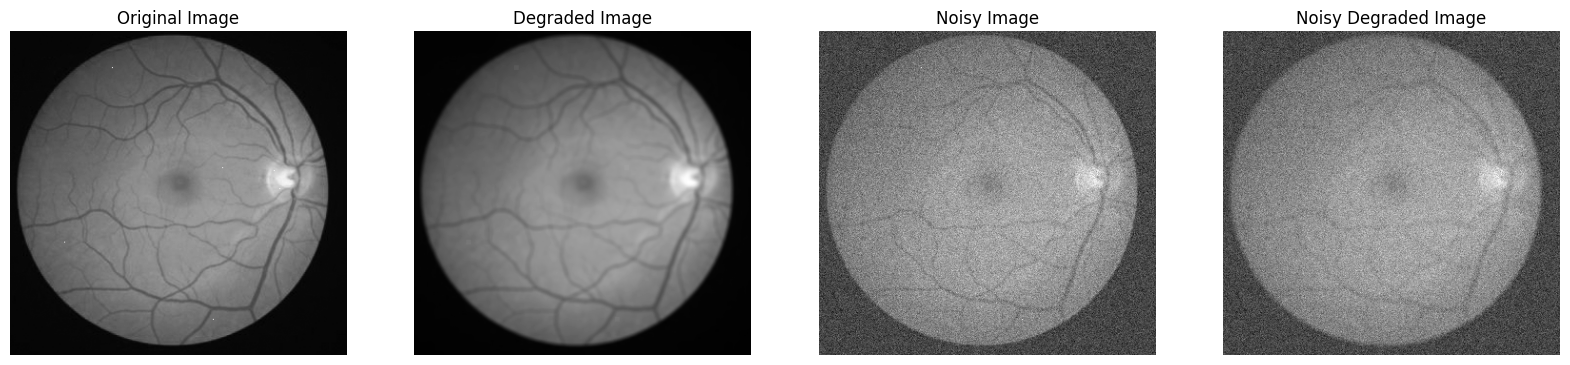

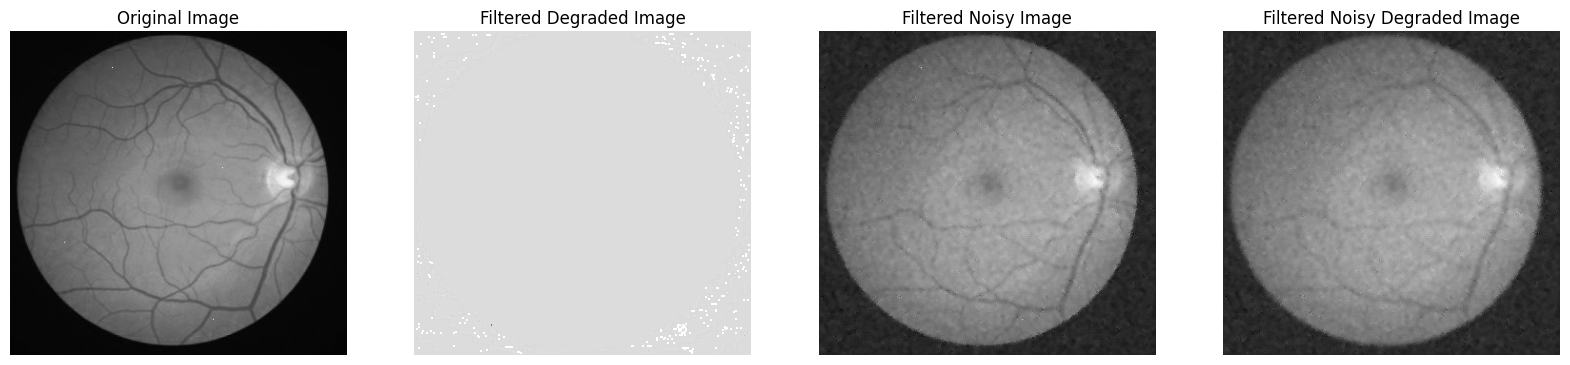

In [19]:
from scipy.signal import wiener

filtered_degraded_image = wiener(degraded_image, (5, 5))
filtered_noisy_image = wiener(noisy_image, (5, 5))
filtered_noisy_degraded_img = wiener(noisy_degraded_img, (5, 5))



plt.figure(figsize=(20, 20))
plt.subplot(2,4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,4, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image')
plt.axis('off')

plt.subplot(2,4, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(2,4, 4)
plt.imshow(noisy_degraded_img, cmap='gray')
plt.title('Noisy Degraded Image')
plt.axis('off')

plt.figure(figsize=(20, 20))
plt.subplot(2,4, 5)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,4, 6)
plt.imshow(filtered_degraded_image, cmap='gray')
plt.title('Filtered Degraded Image')
plt.axis('off')

plt.subplot(2,4, 7)
plt.imshow(filtered_noisy_image, cmap='gray')
plt.title('Filtered Noisy Image')
plt.axis('off')

plt.subplot(2,4, 8)
plt.imshow(filtered_noisy_degraded_img, cmap='gray')
plt.title('Filtered Noisy Degraded Image')
plt.axis('off')

psnr_n=calculate_psnr(image, filtered_noisy_image)
psnr_d=calculate_psnr(image, filtered_degraded_image)
psnr_nd=calculate_psnr(image, filtered_noisy_degraded_img)

print(f'PSNR for degraded image: {psnr_d} dB')
print(f'PSNR for noisy image: {psnr_n} dB')
print(f'PSNR for reconstructed image: {psnr_nd} dB')

# ***Q6***

(-0.5, 536.5, 629.5, -0.5)

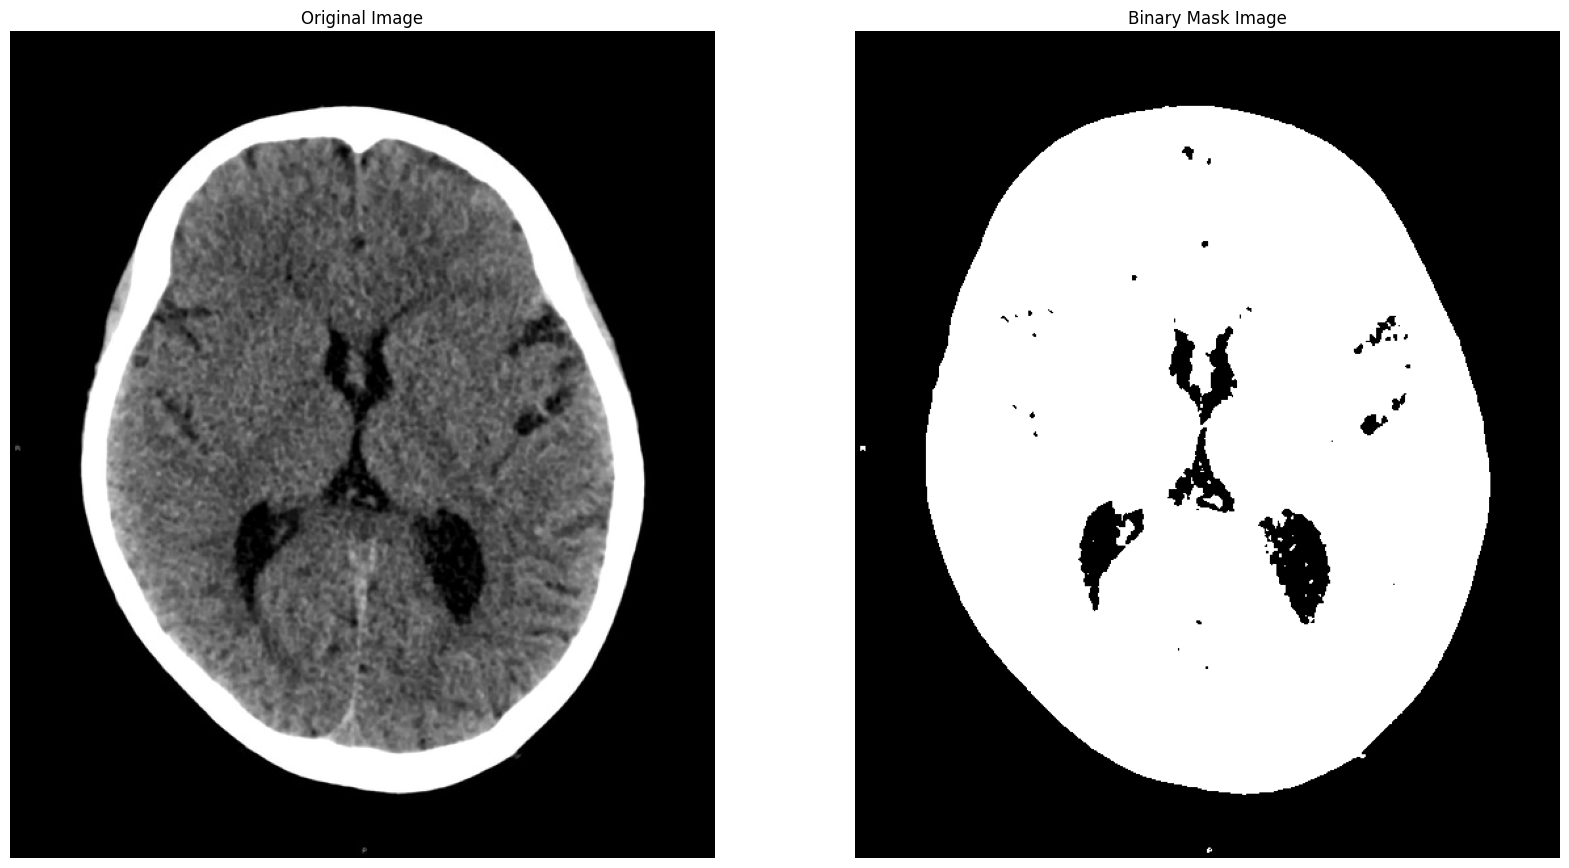

In [20]:
import cv2

# Load the image

file_path = '/content/drive/MyDrive/MIAP/brain_ct.jpeg'
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Define a manual threshold value
threshold_value = 30

# Create a binary mask based on the threshold
binary_mask = (image > threshold_value).astype(int)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask Image')
plt.axis('off')

(-0.5, 536.5, 629.5, -0.5)

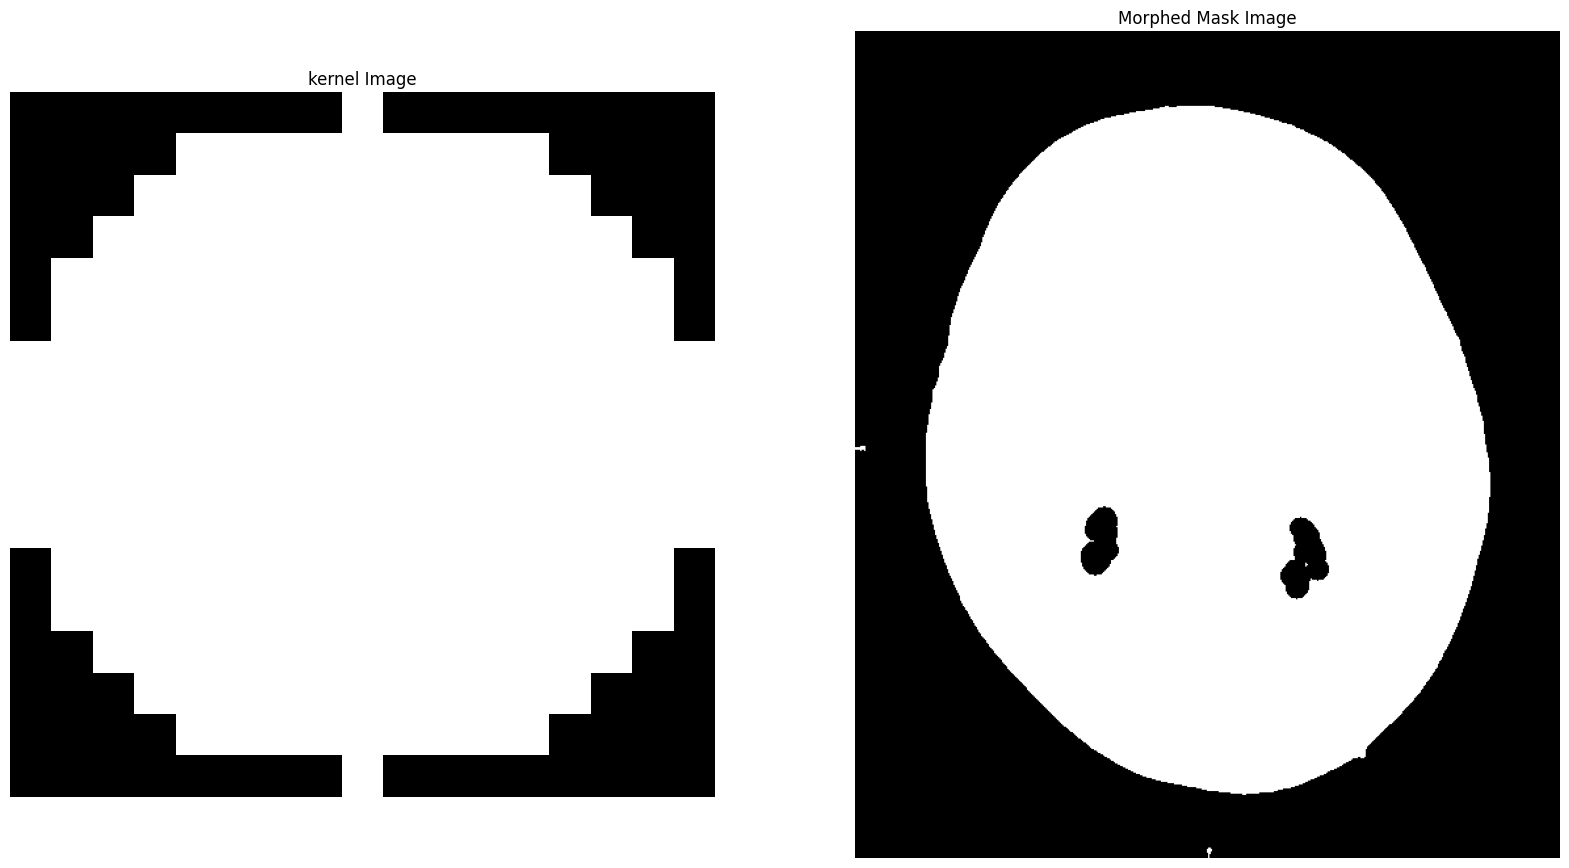

In [21]:
# Apply morphological operations to remove holes in the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17))
morphed_mask = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(kernel, cmap='gray')
plt.title('kernel Image')
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(morphed_mask, cmap='gray')
plt.title('Morphed Mask Image')
plt.axis('off')

(-0.5, 536.5, 629.5, -0.5)

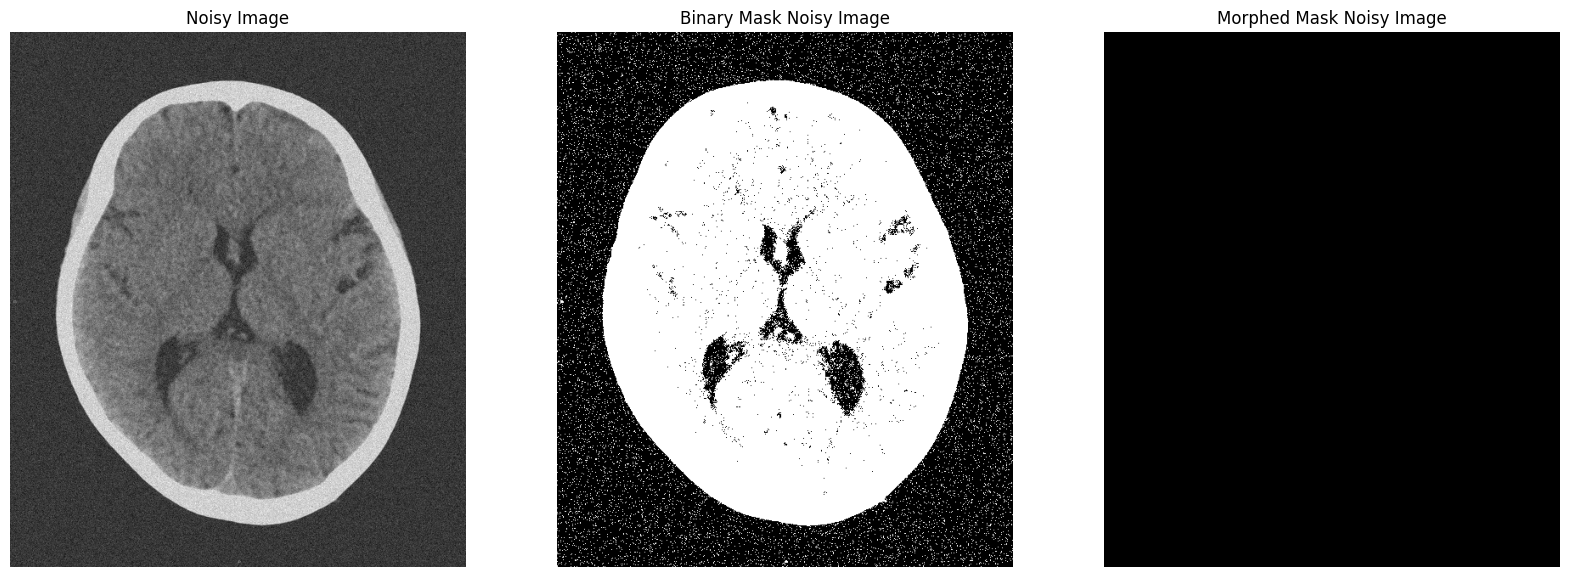

In [22]:
noisy_image = image + np.random.normal(0, 20, image.shape)

# Repeat the thresholding and morphological operations on the noisy image
binary_mask_noisy = (noisy_image > threshold_value).astype(int)
morphed_mask_noisy = cv2.morphologyEx(binary_mask_noisy.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1,3, 2)
plt.imshow(binary_mask_noisy, cmap='gray')
plt.title('Binary Mask Noisy Image')
plt.axis('off')

plt.subplot(1,3, 3)
plt.imshow(morphed_mask_noisy, cmap='gray')
plt.title('Morphed Mask Noisy Image')
plt.axis('off')

بسته به این که مقدار واریانس نویز از مقدار ترشولد ما بیشتر باشد ماسک ما نابود میشود

# ***Q7***

(-0.5, 539.5, 359.5, -0.5)

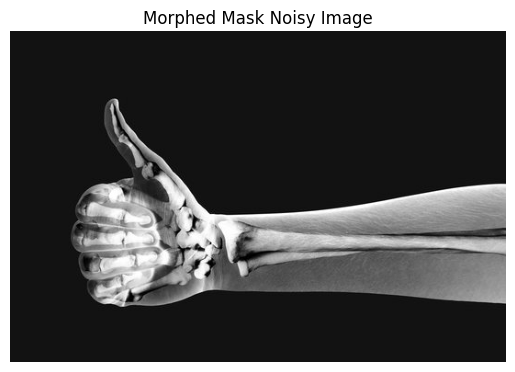

In [23]:
import cv2
import numpy as np

# Load the image


file_path = '/content/drive/MyDrive/MIAP/pca_xray.jpg'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title('Morphed Mask Noisy Image')
plt.axis('off')
# Convert the image to black and white
#image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [24]:
image.shape

(360, 540)

(-0.5, 539.5, 359.5, -0.5)

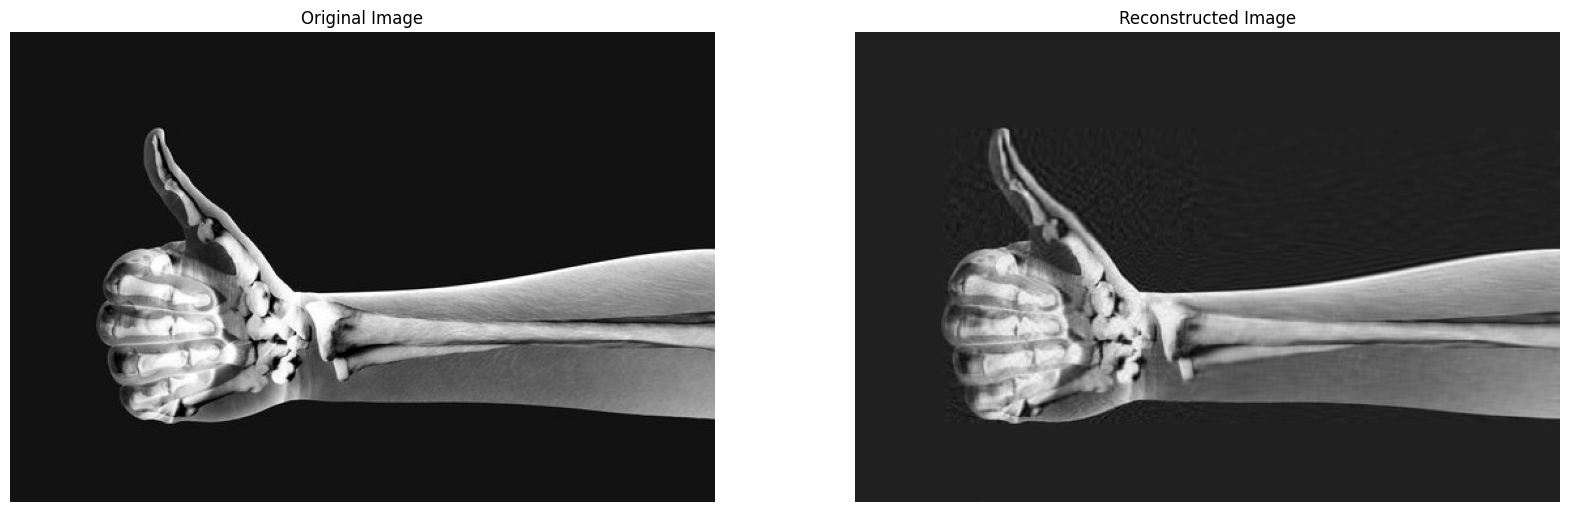

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(image)

image_reconstructed = pca.inverse_transform(pca.transform(image))


plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

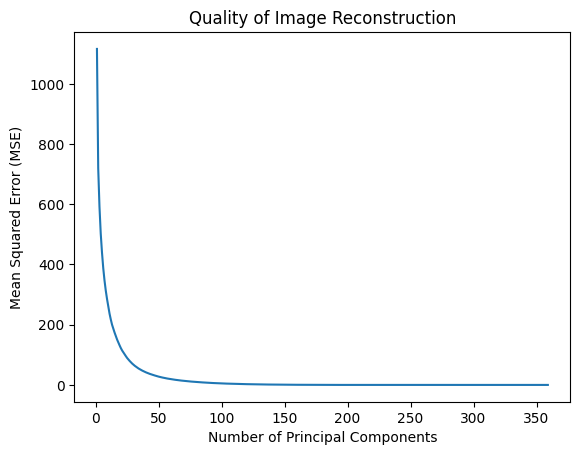

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
components = range(1, 360)

mse_values = []
for n_c in components:
    pca = PCA(n_components=n_c)
    pca.fit(image)
    image_reconstructed = pca.inverse_transform(pca.transform(image))
    mse = mean_squared_error(image, image_reconstructed)
    mse_values.append(mse)

plt.plot(components, mse_values)
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Quality of Image Reconstruction')
plt.show()


# **Q8***

(-0.5, 242.5, 206.5, -0.5)

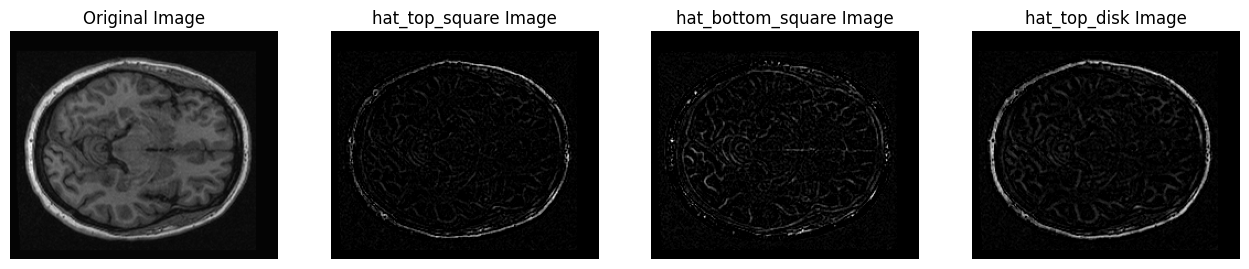

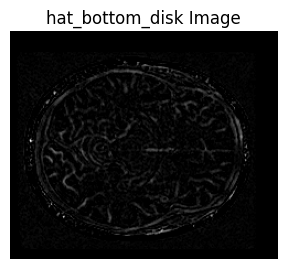

In [27]:
import cv2
import numpy as np


file_path = '/content/drive/MyDrive/MIAP/mri_low_contrast.png'
mri_low_contrast = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

mask_square = np.ones((3, 3), np.uint8)
hat_top_square = cv2.subtract(mri_low_contrast, cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, mask_square))

hat_bottom_square = cv2.subtract(cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, mask_square), mri_low_contrast)

mask_disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

hat_top_disk = cv2.subtract(mri_low_contrast, cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, mask_disk))

hat_bottom_disk = cv2.subtract(cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, mask_disk), mri_low_contrast)

cv2.imwrite('hat_top_square.jpg', hat_top_square)
cv2.imwrite('hat_bottom_square.jpg', hat_bottom_square)
cv2.imwrite('hat_top_disk.jpg', hat_top_disk)
cv2.imwrite('hat_bottom_disk.jpg', hat_bottom_disk)



plt.figure(figsize=(20, 20))
plt.subplot(1,5, 1)
plt.imshow(mri_low_contrast, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,5, 2)
plt.imshow(hat_top_square, cmap='gray')
plt.title('hat_top_square Image')
plt.axis('off')

plt.subplot(1,5, 3)
plt.imshow(hat_bottom_square, cmap='gray')
plt.title('hat_bottom_square Image')
plt.axis('off')

plt.subplot(1,5, 4)
plt.imshow(hat_top_disk, cmap='gray')
plt.title('hat_top_disk Image')
plt.axis('off')

plt.figure(figsize=(20, 20))
plt.subplot(1,5, 5)
plt.imshow(hat_bottom_disk, cmap='gray')
plt.title('hat_bottom_disk Image')
plt.axis('off')


(-0.5, 242.5, 206.5, -0.5)

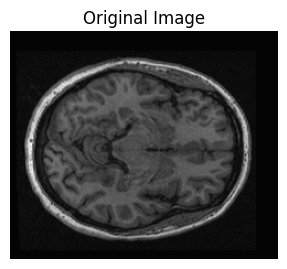

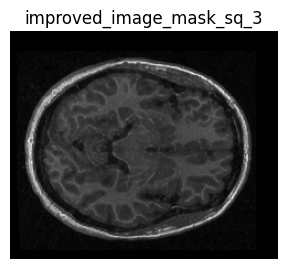

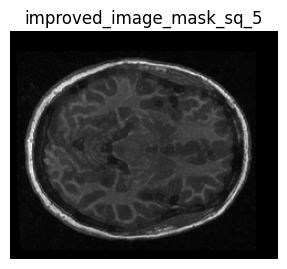

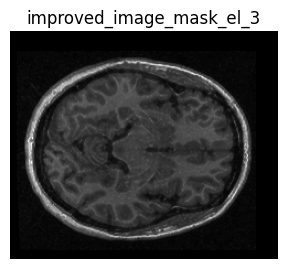

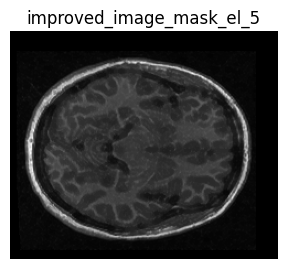

In [47]:
import cv2
import numpy as np

masks = [
    np.ones((3, 3), np.uint8),
    np.ones((5, 5), np.uint8),
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
]

plt.figure(figsize=(20, 20))
plt.subplot(1,5, 1)
plt.imshow(mri_low_contrast, cmap='gray')
plt.title('Original Image')
plt.axis('off')

opening = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
closing = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
improved_image_sq_3 = cv2.addWeighted(mri_low_contrast, 1, cv2.subtract(closing, opening), 1, 0)
cv2.imwrite('improved_image_mask_sq_3.jpg', improved_image_sq_3)
plt.figure(figsize=(20, 20))
plt.subplot(1,5, 2)
plt.imshow(improved_image_sq_3, cmap='gray')
plt.title('improved_image_mask_sq_3')
plt.axis('off')

opening = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
closing = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
improved_image_sq_5 = cv2.addWeighted(mri_low_contrast, 1, cv2.subtract(closing, opening), 1, 0)
cv2.imwrite('improved_image_mask_sq_5.jpg', improved_image_sq_5)
plt.figure(figsize=(20, 20))
plt.subplot(1,5, 3)
plt.imshow(improved_image_sq_5, cmap='gray')
plt.title('improved_image_mask_sq_5')
plt.axis('off')

opening = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
closing = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
improved_image_el_3 = cv2.addWeighted(mri_low_contrast, 1, cv2.subtract(closing, opening), 1, 0)
cv2.imwrite('improved_image_mask_el_3.jpg', improved_image_el_3)
plt.figure(figsize=(20, 20))
plt.subplot(1,5, 4)
plt.imshow(improved_image_el_3, cmap='gray')
plt.title('improved_image_mask_el_3')
plt.axis('off')

opening = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
closing = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
improved_image_el_5 = cv2.addWeighted(mri_low_contrast, 1, cv2.subtract(closing, opening), 1, 0)
cv2.imwrite('improved_image_mask_el_5.jpg', improved_image_el_5)
plt.figure(figsize=(20, 20))
plt.subplot(1,5, 5)
plt.imshow(improved_image_el_5, cmap='gray')
plt.title('improved_image_mask_el_5')
plt.axis('off')

Selecting a mask in proper shape and size to take morphological actions has a key role in achieving desired results and reducing calculation time. In general, the shape and size of a mask are arbitrarily selected; however, the selected mask should be in appropriate shape and size for various diagnosis purposes. Disk-shaped masks (Figure 1) are more commonly used for medical images than other masks. As stated before, since disk-shaped masks are independent of changes in rotation, they are chosen for medical images. Since big or small masks strengthen or weaken various parts of an image, it is impossible to gather detailed information on the contrast of different images using only one structural element. This is why one mask in a particular shape and size may not appropriate for other applications [9] . In the proposed method, the change in shape and size of the mask continues until an appropriate result obtained. It should be mentioned that past experiences have key roles in selecting proper masks to take morphological actions.


In [51]:
def calculate_CIR(image, improved_image, region):
    contrast_values_img = []
    contrast_values_impr_img = []
    for x in range(region):
      for y in range(region):
        p1 = np.mean(image[x-1:x+2, y-1:y+2])
        a1 = np.mean(image[x-3:x+4, y-3:y+4])
        c1 = abs(p1 - a1) / abs(p1 + a1)

        p = np.mean(improved_image[x-1:x+2, y-1:y+2])
        a = np.mean(improved_image[x-3:x+4, y-3:y+4])
        c = abs(p - a) / abs(p + a)
        if (abs(p + a) )>0 and abs(p1 + a1)>0  :
          contrast_values_impr_img.append(c)
          contrast_values_img.append(c1)
    contrast_values_img = np.array(contrast_values_img)
    contrast_values_impr_img = np.array(contrast_values_impr_img)
    CIR = np.sum((contrast_values_img - contrast_values_impr_img)**2) /np.sum((contrast_values_img)**2)
    return CIR


shapes=mri_low_contrast.shape
minreg=min([shapes[0],shapes[1]])
CIR_value = calculate_CIR(mri_low_contrast, improved_image_el_5, minreg)
print("CIR value for the specified region:", CIR_value)


CIR value for the specified region: 0.24391848888006123


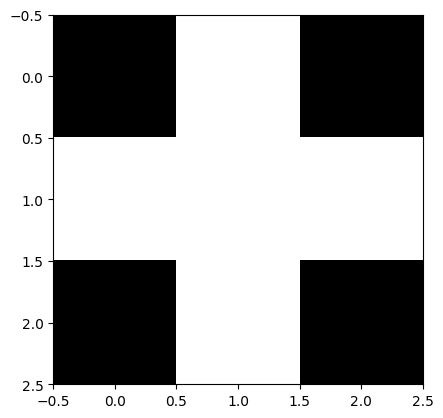

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


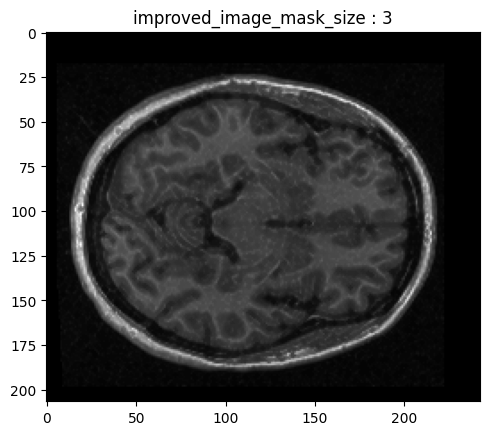

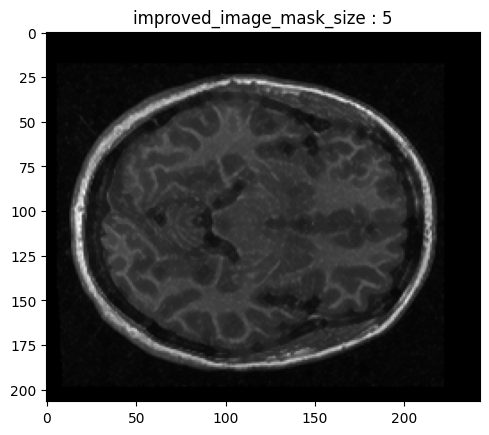

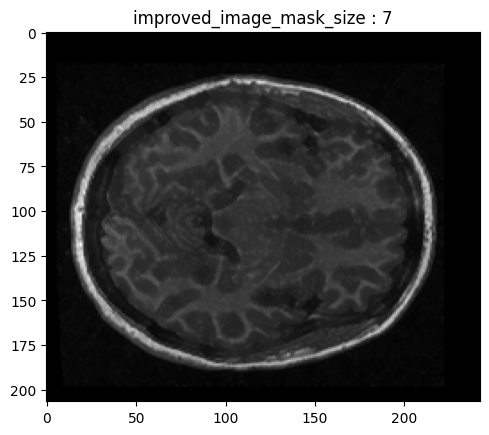

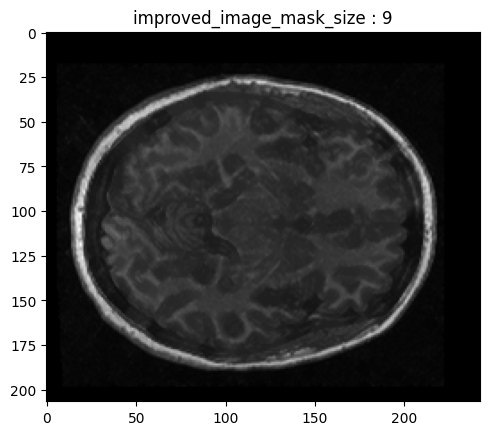

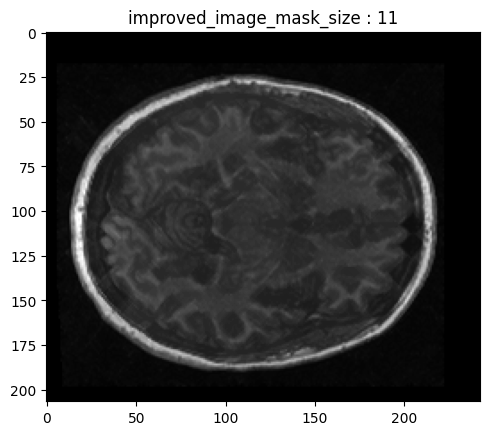

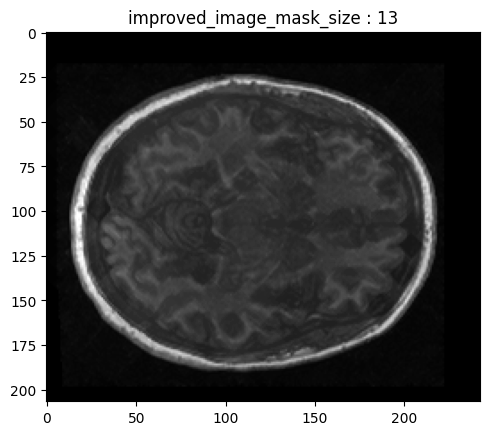

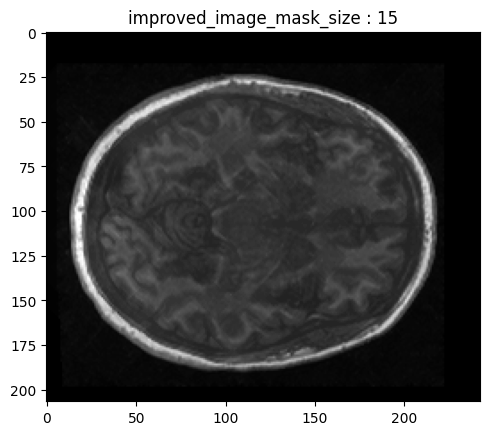

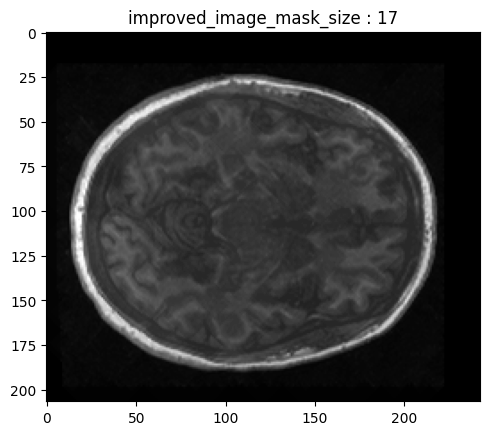

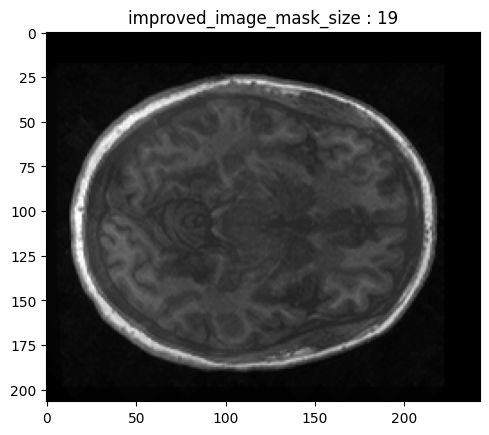

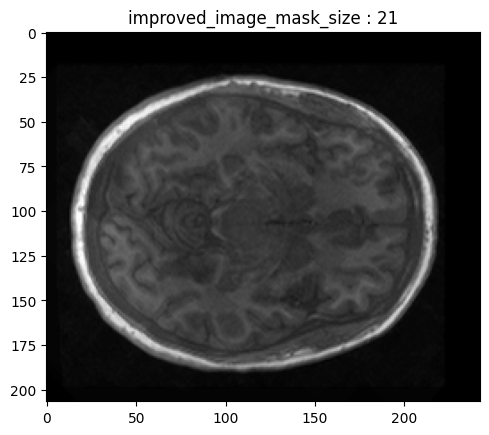

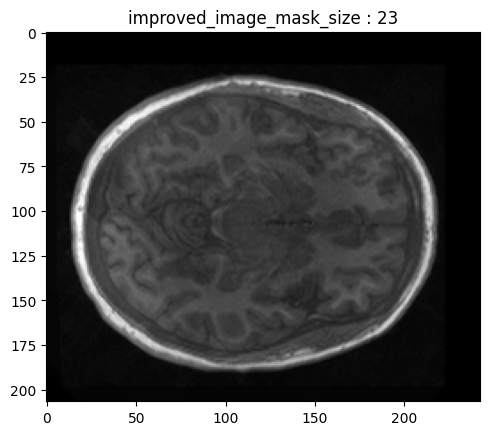

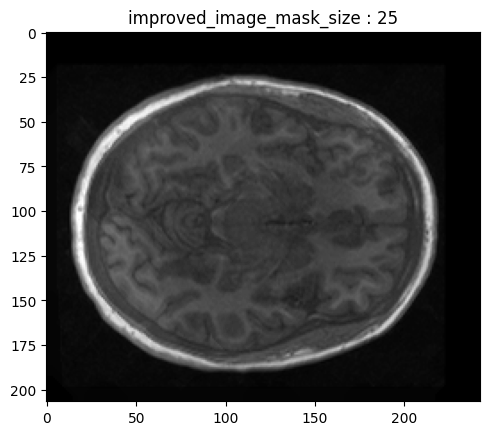

In [82]:
mask_size=3
mask_in=np.zeros((20,20))
mask_in[10,10]=1

shapes=mri_low_contrast.shape
minreg=min([shapes[0],shapes[1]])

plt.imshow(cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (mask_size, mask_size)), cmap='gray')
plt.show()
CIRs=[]
best_CIR=0
for i in range(12):
  mask_in=cv2.dilate(mask_in, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (mask_size, mask_size)))
  mask_in=np.uint8(mask_in)
  opening = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_OPEN, mask_in)
  closing = cv2.morphologyEx(mri_low_contrast, cv2.MORPH_CLOSE, mask_in)
  improved_image = cv2.addWeighted(mri_low_contrast, 1, cv2.subtract(closing, opening), 1, 0)
  CIR_value = calculate_CIR(mri_low_contrast, improved_image, minreg)
  if best_CIR<CIR_value:
   best_improved_img=improved_image
   best_CIR = CIR_value
  CIRs.append(CIR_value)
  plt.imshow(improved_image, cmap='gray')
  plt.title(f'improved_image_mask_size : {(i+1)*2+1}')
  plt.show()

In [84]:
max_ind=CIRs.index(max(CIRs))
max_size=(max_ind+1)*2+1
max_size

9

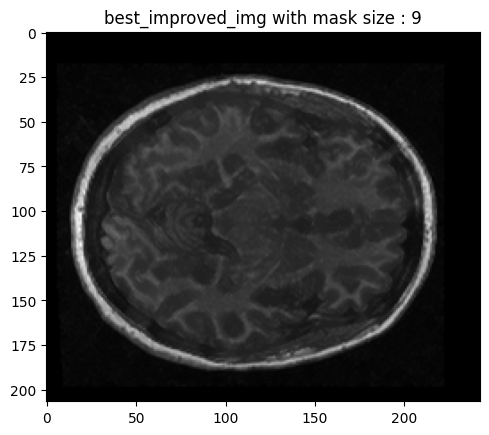

best_CIR :  0.35203157517067324 
 best mask size :  9


In [88]:
plt.imshow(best_improved_img, cmap='gray')
plt.title(f'best_improved_img with mask size : {max_size}')
plt.show()
cv2.imwrite('best_improved_img_with_mask_size_9.jpg', best_improved_img)
print("best_CIR : ",best_CIR , "\n best mask size : ",max_size)